# Read in a FITS file and output a VTK file for Paraview

In this example I am assuming a datacube (x, y, velocity) in .fits format.

The convertToVTK function below can be adapted to work with other data types as well

### Grab some FITS data

http://learn.astropy.org/rst-tutorials/FITS-cubes.html

In [4]:
from astropy.utils.data import download_file
from astropy.io import fits  # We use fits to open the actual data file

In [8]:
# Downloads the HI data in a fits file format
hi_datafile = download_file(
    'http://data.astropy.org/tutorials/FITS-cubes/'+'reduced_TAN_C14.fits',
    cache= False, show_progress = True)

In [10]:
# read and write to a local file
hi_data = fits.open(hi_datafile)  
hi_data.writeto('reduced_TAN_C14.fits',overwrite=True)
hi_data.close()  


### Read in the FITS file

http://docs.astropy.org/en/stable/io/fits/

https://python4astronomers.github.io/astropy/fits.html

In [11]:
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

%matplotlib notebook

In [12]:
fname = 'reduced_TAN_C14.fits'

In [13]:
#check the fits info
with fits.open(fname) as hdul:
    hdul.info()
    print(hdul[0].header)

Filename: reduced_TAN_C14.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      45   (150, 150, 450)   float32   
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                  150                                                  NAXIS2  =                  150                                                  NAXIS3  =                  450                                                  OBJECT  = 'HI4PI   '           / The HI 4-PI Survey                             TELESCOP= 'Effelsberg 100m RT; ATNF Parkes 64-m' / Telescope names              ORIGIN  = 'AIfA/MPIfR Bonn; ATNF Sydney' / Organisations or Institutions        REFERENC= 'HI4PI Collaboration 2016' / A&A                                      RESTFRQ =        1420405751.77      

(450, 150, 150)


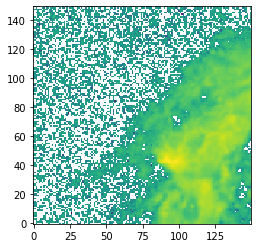

In [20]:
#get the data 
data = fits.getdata(fname, 0)
print(data.shape)
plt.imshow(data[300,:,:], origin='lower', norm=LogNorm())

### Convert this to VTK

*NOTE 1: Structured grid data can only be volume rendered in Paraview with an additional "iso volume" filter applied.  At least on my laptop this operation is VERY slow.  Unstructured grid and image data, can be rendered as volume without an additional filter.*

*NOTE 2: OSPRay rendering must be enabled in Paraview for this to look correct!  (Not sure why)*

https://vtk.org/Wiki/VTK/Writing_VTK_files_using_python

https://bitbucket.org/pauloh/pyevtk

In [22]:
from pyevtk.hl import gridToVTK, imageToVTK 

In [23]:
def convertToVTK(data, outfile, image = True, grid = True ):

    # Dimensions 
    nz, nx, ny = data.shape #NOTE: here the spectral dimension is "z" and is in array location 0
    lx, ly, lz = 1.0, 1.0, 1.0 
    dx, dy, dz = lx/nx, ly/ny, lz/nz 

    ncells = nx * ny * nz 
    npoints = (nx + 1) * (ny + 1) * (nz + 1) 

    # Coordinates (scaled to [0,1])
    x = np.arange(0, lx + 0.1*dx, dx, dtype='float64') 
    y = np.arange(0, ly + 0.1*dy, dy, dtype='float64') 
    z = np.arange(0, lz + 0.1*dz, dz, dtype='float64') 
        
    # Variables (probably a one-liner way to create this
    intensity = np.empty((nx, ny, nz))
    for i in range(nz):
        intensity[:,:,i] = data[i,:,:]

    #for log intensity values
    check = intensity.flatten()
    w = np.where(check > 0)
    mval = np.log10(min(check[w])) -1
    log10intensity = np.empty((nx, ny, nz))
    for i in range(nz):
        log10intensity[:,:,i] = np.ma.log10(data[i,:,:]).filled(mval)
               
    #should this be "pointData" instead?
    if (image):
        imageToVTK(outfile, cellData = {"intensity" : intensity,"log10intensity" : log10intensity}) 
        
    if (grid):
        gridToVTK(outfile, x,y,z, cellData = {"intensity" : intensity,"log10intensity" : log10intensity}) 



In [24]:
convertToVTK(data,'reduced_TAN_C14')

/Users/ageller/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
